In [53]:
from flask import Flask, render_template, request
import requests
import pandas as pd
import re
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import nltk
from nltk import pos_tag
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
import numpy as np

In [54]:
def parse_for_word(row, keyword):
    has_keyword = 0
    text = row["Review"]
    #print (text + "\n")
    average_sentiment = 0
    for word in text.split(" "):
        if keyword in word:
            has_keyword = 1
    if (has_keyword > 0):
        sentence_list, average_sentiment = get_sentences_with_word(text, keyword, row)
    else:
        sentence_list = []
        combined_score = 0
    return has_keyword, sentence_list, average_sentiment

def get_sentences_with_word(text, keyword, row):
    average_sentiment = 0
    number_of_sentences = 0
    list_of_sentences = []
    #print(text)
    sentences = tokenize.sent_tokenize(text)
    for sentence in sentences:
        #print (sentence)
        if keyword in sentence:
            list_of_sentences.append(sentence)
            number_of_sentences = number_of_sentences + 1
            sentiment = get_sentiment(sentence)
            print(sentence, sentiment, row["sentiment_vader"])
    average_sentiment = float(sentiment / number_of_sentences)
    return list_of_sentences, average_sentiment

def get_sentiment(text):
    sentiment = SentimentIntensityAnalyzer() #### calling Intensity Analyzer
    compound = sentiment.polarity_scores(text)['compound']  ### calling the 'compound' score for the "text" entered
    #if compound > 0:
    #    return 1  ## positive
    #else:
    #    return 0 ## negative
    #else:
        #return "Neutral"     
    #print(compound)
    return compound

In [55]:
f=open("db.txt", "r")
contents=0
if not(contents):
    contents = f.read()
username = contents.split("\n")[0]
password = contents.split("\n")[1]
dbname_photos = 'photos_db'
dbname_reviews = "reviews_db"

In [56]:
con = psycopg2.connect(database = dbname_reviews, user = username, password = password, port=5432, host= "/var/run/postgresql/")
sql_query_reviews = """
SELECT * FROM reviews_data_table;
"""
reviews_data_from_sql = pd.read_sql_query(sql_query_reviews,con)
con.close()

In [57]:
keyword = "balayage"

In [58]:
reviews_data_from_sql = reviews_data_from_sql.drop(axis = 1, columns=["index"])
print(reviews_data_from_sql.shape)
print(reviews_data_from_sql.drop_duplicates().shape)
reviews_data_from_sql = reviews_data_from_sql.drop_duplicates()

(16111, 3)
(16111, 3)


In [59]:
reviews_data_from_sql.head()

,Review,Title,sentiment_vader
0,Love this salon! I was referred over by two of...,Urban Betty,0.369429
1,Came in for a summer haircut since my hair was...,Urban Betty,0.026473
2,I recently moved and have been looking for a g...,Urban Betty,-0.059000
3,Y'all stop what you are doing right now and go...,Urban Betty,0.514370
4,"Love, love, love this place! I saw Holly and s...",Urban Betty,0.725425


In [60]:
%%time
reviews_data_from_sql["has_keyword"], reviews_data_from_sql["sentence_list"], reviews_data_from_sql["average_sentiment_sentence"] = zip(*reviews_data_from_sql.apply(parse_for_word, keyword = keyword, axis=1))

Rachael gave me an amazing hair cut with a beautiful ashy blonde balayage. 0.765 0.502283333333333
Rachael did a great job with the balayage, she is definitely someone I would recommend! 0.8622 0.407057142857143
She's SO talented and made my first major cut, bangs, and balayage a wonderful (and not at all scary) experience. 0.7861 0.509485714285714
Lauren did my balayage today and I've never been so happy with my hair!! 0.745 0.463188888888889
Katie is a balayage pro and will help you rock your best hair ever. 0.7845 0.69838
Visited Urban Betty for the first time wanting one all over color to get rid of my balayage that I had for forever and wasn't loving anymore. -0.4847 0.0198565217391304
During the next appointment I got real with my stylist and told her it was too dark and unnatural looking, so this time we did some partial foils to create a "faux balayage" to help lift that darker color. 0.5859 0.0198565217391304
As you might know, balayage is a specialty color service - therefore

In [61]:
reviews_data_from_sql.head()

,Review,Title,sentiment_vader,has_keyword,sentence_list,average_sentiment_sentence
0,Love this salon! I was referred over by two of...,Urban Betty,0.369429,0,[],0.0
1,Came in for a summer haircut since my hair was...,Urban Betty,0.026473,0,[],0.0
2,I recently moved and have been looking for a g...,Urban Betty,-0.059000,0,[],0.0
3,Y'all stop what you are doing right now and go...,Urban Betty,0.514370,0,[],0.0
4,"Love, love, love this place! I saw Holly and s...",Urban Betty,0.725425,0,[],0.0


In [62]:
# remove rows where the keyword doesn't occur
reviews_data_from_sql = reviews_data_from_sql[reviews_data_from_sql.has_keyword != 0]
reviews_data_from_sql.head()
reviews_data_from_sql.iloc[0][5]

0.765

In [63]:
d = {'has_keyword':'has_keyword_sum', 'average_sentiment_sentence':'average_sentiment_sentence_average',
     'sentiment_vader':'sentiment_vader_average', 'sentence_list':'sentence_list_combined',
     'Review': 'Review_sum'}
sorted_mean_by_Title=reviews_data_from_sql.groupby('Title', as_index = False).agg({'has_keyword':'sum',
                                                                'average_sentiment_sentence':'mean',
                                                                'sentiment_vader':'mean',
                                                                'sentence_list':'sum',
                                                                'Review':'sum'}).rename(columns=d)
sorted_mean_by_Title.sort_values(by=['has_keyword_sum'], ascending=False, inplace=True)
sorted_mean_by_Title.head(5)

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum
115,Wild Orchid Salon,40,0.282046,0.302733,[I had an appointment with Renee and told her ...,I had a terrible experience when I went in for...
48,Jose Luis Salon & Boutique,30,0.281530,0.284283,[No exaggeration- whether I come in asking her...,I've been coming here for over a year and have...
80,Red Stella Hair Salon,26,0.226553,0.325903,[She did an amazing job with my cut and balaya...,Caily was looking for hair models and I volunt...
109,Urban Betty,24,0.293259,0.352971,[Rachael gave me an amazing hair cut with a be...,I went to go see my friend Rachael to get my h...
20,CNN Hair Team Salon,16,0.141069,0.253464,[At my consultation I asked for a light brown ...,At my consultation I asked for a light brown a...


In [64]:
def scaled_combined_score(row):
    # get the values
    sentiment_score = float(row["average_sentiment_sentence_average"])
    has_keyword_sum = int(row["has_keyword_sum"])
    sentiment_vader = float(row["sentiment_vader_average"])
    # update the sentiment value
    return (combined_function(has_keyword_sum, sentiment_score, sentiment_vader))

def combined_function(has_keyword_sum, sentiment_score, sentiment_vader):
    weight = 0
    if (has_keyword_sum >= 3):
        weight = 0.7
    else:
        alpha = -0.07777
        beta = 0.46666
        weight = alpha * has_keyword_sum * has_keyword_sum + beta * has_keyword_sum
        #print(weight)
    #print(weight, sentiment_score, sentiment_vader)
    return weight * sentiment_score + 0.3 * sentiment_vader

In [65]:
sorted_mean_by_Title['final_score'] = sorted_mean_by_Title.apply(scaled_combined_score, axis=1)
sorted_review_data = sorted_mean_by_Title.sort_values(by=['final_score'], ascending=False)
sorted_review_data.head()

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score
29,Emily Hello Hair Stylist,2,0.836400,0.477052,"[Emily took one look, showed me the damage - I...",Emily is magic - she swiftly (and kindly) resc...,0.663557
25,Dolce,2,0.719900,0.506393,"[He has dyed my hair, did a balayage and gave ...",I am so thankful I found Pedro Boelitz and he ...,0.599869
42,Hair by Tanya Faris,2,0.665250,0.603600,[Tanya did an AMAZING job with my balayage and...,Tanya did an AMAZING job with my balayage and ...,0.595025
47,Janet St. Paul Studio for Hair and Beauty,4,0.711100,0.281618,"[Full disclosure, I had great experiences with...","Hi Folks, I should have written this review a...",0.582255
2,Amy Salas,4,0.591125,0.560383,"[Amy did a balayage and it was amazing!, Loved...",I hadn't dyed my hair in years and wanted to g...,0.581902


In [66]:
row = sorted_review_data.loc[sorted_review_data['Title'] == "Method.Hair"]
print(row)

          Title  has_keyword_sum  average_sentiment_sentence_average  \
64  Method.Hair               10                             0.27563   

    sentiment_vader_average  \
64                 0.426844   

                               sentence_list_combined  \
64  [Her balayage and cutting skills are excellent...   

                                           Review_sum  final_score  
64  Today was my first experience at Method and Zo...     0.320994  


In [67]:
sorted_review_data.iloc[0][6]

0.6635571610000001

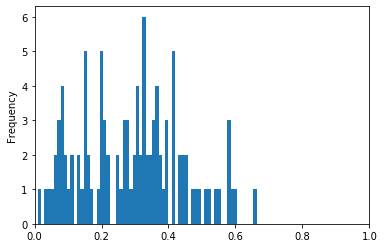

In [68]:
sorted_mean_by_Title.final_score.plot.hist(bins = 100, xlim=[0, 1])

In [15]:
list_of_salons_titles_from_insta = ['Urban Betty', 'Method.Hair', 'Red Stella Hair Salon', 'Topaz Salon', 'Garbo A Salon and Spa',
                                        "Frenchy's Beauty Parlor", 'Black Orchid Salon', 'CNN Hair Team Salon', 'Chuck Edwards The Salon',
                                        'Benjamin Beau Salon', 'Vain', 'Love + Roots', 'Wild Orchid Salon', 'Salon Sovay', 'The Salon at The Domain',
                                        'Ritual Salon', 'Bella Salon', 'SALON by milk + honey', 'Path Salon', 'WaterStone Salon']
type(list_of_salons_titles_from_insta)

list

In [16]:
sorted_review_data["in_insta"] = sorted_review_data.Title.isin(list_of_salons_titles_from_insta)
sorted_review_data.head()

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
29,Emily Hello Hair Stylist,2,0.836400,0.974800,"[Emily took one look, showed me the damage - I...",Emily is magic - she swiftly (and kindly) resc...,0.812882,False
25,Dolce,2,0.719900,0.989300,"[He has dyed my hair, did a balayage and gave ...",I am so thankful I found Pedro Boelitz and he ...,0.744741,False
102,Stylin,2,0.707550,0.979700,[She created a beautiful red-violet balayage f...,After my first appointment at Stylin Salon and...,0.734176,False
2,Amy Salas,4,0.591125,0.981525,"[Amy did a balayage and it was amazing!, Loved...",I hadn't dyed my hair in years and wanted to g...,0.708245,False
42,Hair by Tanya Faris,2,0.665250,0.956450,[Tanya did an AMAZING job with my balayage and...,Tanya did an AMAZING job with my balayage and ...,0.700880,False


In [17]:
salon_data_with_insta_df = sorted_review_data[sorted_review_data.in_insta == True]
salon_data_with_insta_df.head()

,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
21,Chuck Edwards The Salon,6,0.512500,0.965317,[I got balayage which she does a beautiful job...,I love Cat!! She's amazing with color and terr...,0.648345,True
106,The Salon at The Domain,8,0.408975,0.783550,[I recently tried a new balayage style and she...,I moved to Austin last summer and tried a coup...,0.521347,True
111,Vain,7,0.308314,0.917614,"[She definitely seems to prefer balayage, and ...",So I gave this 3 stars because this situation ...,0.491104,True
64,Method.Hair,10,0.275630,0.954990,[Her balayage and cutting skills are excellent...,Today was my first experience at Method and Zo...,0.479438,True
109,Urban Betty,24,0.293259,0.822913,[Rachael gave me an amazing hair cut with a be...,I went to go see my friend Rachael to get my h...,0.452155,True


In [18]:
salon_data_with_insta_df.iloc[0][0]

'Chuck Edwards The Salon'

In [73]:
con = psycopg2.connect(database = "photos_db", user = username, password = password, port=5432, host= "/var/run/postgresql/")
sql_query_photos = """
SELECT * FROM photos_data_table;
"""
insta_data_from_sql = pd.read_sql_query(sql_query_photos,con)
con.close()

In [74]:
insta_data_from_sql.drop(columns=["index"], inplace=True)

In [75]:
insta_data_from_sql.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence
0,2018-02-04_14-34-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([2.9389e-04, 5....",colored,0.49703
1,2018-02-04_14-42-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([5.8816e-04, 3....",colored,0.99762
2,2018-02-04_15-01-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.8565e-04, 9.5...",blonde,0.95877
3,2018-02-04_15-03-08_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.4672e-06, 9.9...",blonde,0.99927
4,2018-02-04_15-06-30_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([3.8139e-05, 1....",colored,0.99979


In [76]:
merged_salon_insta = pd.merge(insta_data_from_sql, salon_data_with_insta_df, left_on='salon_name', right_on='Title')

In [77]:
merged_salon_insta.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
0,2018-02-04_14-34-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([2.9389e-04, 5....",colored,0.49703,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
1,2018-02-04_14-42-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([5.8816e-04, 3....",colored,0.99762,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
2,2018-02-04_15-01-36_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.8565e-04, 9.5...",blonde,0.95877,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
3,2018-02-04_15-03-08_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"blonde -- tensor(1) -- tensor([7.4672e-06, 9.9...",blonde,0.99927,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True
4,2018-02-04_15-06-30_UTC.jpg,/home/cjdavis/insight/instaloader/salons/acess...,acessalon,Chuck Edwards The Salon,"colored -- tensor(3) -- tensor([3.8139e-05, 1....",colored,0.99979,Chuck Edwards The Salon,10,0.26013,0.92716,[Has plenty of parking and everyone who works ...,Please note: I am a person that has gone to th...,0.460239,True


In [80]:
merged_salon_insta_red = merged_salon_insta[merged_salon_insta.prediction == "black"]

In [81]:
merged_salon_insta_red.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
27,2018-11-06_15-17-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([8.8020e-01, 3.33...",black,0.88020,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
104,2019-05-17_13-18-49_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([6.5030e-01, 1.05...",black,0.65030,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
128,2017-10-10_03-41-31_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([8.0681e-01, 1.19...",black,0.80681,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
131,2017-10-28_12-13-17_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([7.2795e-01, 5.34...",black,0.72795,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
141,2018-02-21_14-24-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([6.7433e-01, 1.58...",black,0.67433,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True


In [82]:
sorted_merged_salon_insta_red = merged_salon_insta_red.sort_values(by=['final_score'], ascending=False)

In [110]:
sorted_merged_salon_insta_red.salon_name.unique()[0]

'WaterStone Salon'

In [94]:
highest_salon = sorted_merged_salon_insta_red.salon_name.unique()[1]

In [95]:
sorted_merged_salon_insta_red.head(5)

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
1240,2018-02-20_23-20-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8780e-01, 1.30...",black,0.98780,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1303,2019-05-23_15-29-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([7.7606e-01, 2.78...",black,0.77606,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1230,2017-11-28_20-38-42_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([0.4705, 0.0461, ...",black,0.47050,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1212,2017-06-23_22-10-31_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([0.6146, 0.0010, ...",black,0.61460,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1249,2018-03-29_19-16-12_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.2139e-01, 1.19...",black,0.92139,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True


In [98]:
sorted_merged_salon_insta_red_highest = sorted_merged_salon_insta_red[sorted_merged_salon_insta_red.salon_name == highest_salon]
sorted_merged_salon_insta_red_highest

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
719,2019-06-11_23-49-17_UTC_6.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([6.5062e-01, 3.87...",black,0.65062,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
697,2019-05-28_18-05-47_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([7.0635e-01, 3.23...",black,0.70635,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [99]:
confidence_ranked_merged_salon_insta_red_highest = sorted_merged_salon_insta_red_highest.sort_values(by=['confidence'], ascending=False)
confidence_ranked_merged_salon_insta_red_highest.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
697,2019-05-28_18-05-47_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([7.0635e-01, 3.23...",black,0.70635,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [121]:
confidence_ranked_merged_salon_insta_red_highest.iloc[0][13]

0.6106565625

# Start new section to find a ranked list of the highest scores for photos #

In [125]:
merged_salon_insta_red.head()

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
27,2018-11-06_15-17-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([8.8020e-01, 3.33...",black,0.88020,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
104,2019-05-17_13-18-49_UTC.jpg,/home/cjdavis/insight/instaloader/salons/benja...,benjaminbeausalon,Benjamin Beau Salon,"black -- tensor(0) -- tensor([6.5030e-01, 1.05...",black,0.65030,Benjamin Beau Salon,6,0.320083,0.983567,[I did have to call in to make sure that they ...,Benjamin Beau salon is the most integrative an...,0.519128,True
128,2017-10-10_03-41-31_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([8.0681e-01, 1.19...",black,0.80681,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
131,2017-10-28_12-13-17_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([7.2795e-01, 5.34...",black,0.72795,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True
141,2018-02-21_14-24-04_UTC.jpg,/home/cjdavis/insight/instaloader/salons/cnnha...,cnnhairteam,CNN Hair Team Salon,"black -- tensor(0) -- tensor([6.7433e-01, 1.58...",black,0.67433,CNN Hair Team Salon,6,0.399067,0.965217,[Parking is free and there is a parking garage...,I got a digital perm here and Tommy did an ama...,0.568912,True


In [164]:
sorted_merged_salon_insta_red = merged_salon_insta_red.sort_values(by=['final_score'], ascending=False)
sorted_merged_salon_insta_red_good_score = sorted_merged_salon_insta_red[sorted_merged_salon_insta_red.confidence >= 0.8]


In [166]:
sorted_merged_salon_insta_red_good_score.shape

(33, 15)

In [168]:
sorted_merged_salon_insta_red_good_score.head(50)

,photo_path,salon_local_path,instagram_name,salon_name,classified,prediction,confidence,Title,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score,in_insta
1240,2018-02-20_23-20-41_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8780e-01, 1.30...",black,0.98780,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1249,2018-03-29_19-16-12_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.2139e-01, 1.19...",black,0.92139,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1287,2019-01-09_00-54-07_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([8.6568e-01, 3.72...",black,0.86568,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1302,2019-05-22_14-21-11_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.9572e-01, 1.32...",black,0.99572,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1224,2017-09-26_22-35-09_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.3614e-01, 3.91...",black,0.93614,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
1309,2019-06-07_20-47-48_UTC.jpg,/home/cjdavis/insight/instaloader/salons/water...,waterstone_salon,WaterStone Salon,"black -- tensor(0) -- tensor([9.8086e-01, 6.97...",black,0.98086,WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...,0.692454,True
670,2019-05-03_04-33-56_UTC_2.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5786e-01, 9.81...",black,0.95786,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
691,2019-05-20_16-26-26_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.9514e-01, 3.26...",black,0.99514,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
683,2019-05-11_18-20-45_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.4213e-01, 1.57...",black,0.94213,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True
677,2019-05-07_16-02-02_UTC.jpg,/home/cjdavis/insight/instaloader/salons/redst...,redstellasalon,Red Stella Hair Salon,"black -- tensor(0) -- tensor([9.5756e-01, 1.07...",black,0.95756,Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...,0.610657,True


In [169]:
end_photo_list = []
number_of_photos = min(10, sorted_merged_salon_insta_red.shape[0])
indices = np.random.choice(sorted_merged_salon_insta_red.shape[0], size = number_of_photos, replace = False)
print(indices)
for index in indices:
    photo_information = []
    photo_name = sorted_merged_salon_insta_red.iloc[index][0]
    photo_location = "/static/img/" + sorted_merged_salon_insta_red.iloc[index][2] + "/" + photo_name
    instagram_name = sorted_merged_salon_insta_red.iloc[index][2]
    score = sorted_merged_salon_insta_red.iloc[index][13]
    photo_information.extend((photo_location, instagram_name, score))
    end_photo_list.append(photo_information)
print(end_photo_list)

[17 34 40 15 20 29 26 12 16 21]
[['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_7.jpg', 'ritualsalonatx', 0.58344], ['/static/img/urbanbettysalon/2019-04-25_18-35-34_UTC_1.jpg', 'urbanbettysalon', 0.4931936363636364], ['/static/img/wildorchidatx/2019-02-16_15-19-09_UTC_2.jpg', 'wildorchidatx', 0.491545], ['/static/img/redstellasalon/2019-05-28_18-05-47_UTC.jpg', 'redstellasalon', 0.6106565625], ['/static/img/ritualsalonatx/2019-01-22_19-23-35_UTC_1.jpg', 'ritualsalonatx', 0.58344], ['/static/img/benjaminbeausalon/2018-11-06_15-17-04_UTC.jpg', 'benjaminbeausalon', 0.5191283333333334], ['/static/img/cnnhairteam/2019-02-27_02-48-28_UTC.jpg', 'cnnhairteam', 0.5689116666666666], ['/static/img/redstellasalon/2019-05-20_16-26-26_UTC.jpg', 'redstellasalon', 0.6106565625], ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_3.jpg', 'ritualsalonatx', 0.58344], ['/static/img/ritualsalonatx/2019-01-29_18-39-37_UTC.jpg', 'ritualsalonatx', 0.58344]]


In [175]:
def takeThird(elem):
    return elem[2]
end_photo_list.sort(key=takeThird, reverse=True)
end_photo_list

[['/static/img/redstellasalon/2019-05-20_16-26-26_UTC.jpg',
  'redstellasalon',
  0.6106565625],
 ['/static/img/redstellasalon/2019-05-28_18-05-47_UTC.jpg',
  'redstellasalon',
  0.6106565625],
 ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_3.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2018-10-31_19-09-35_UTC_7.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2019-01-22_19-23-35_UTC_1.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/ritualsalonatx/2019-01-29_18-39-37_UTC.jpg',
  'ritualsalonatx',
  0.58344],
 ['/static/img/cnnhairteam/2019-02-27_02-48-28_UTC.jpg',
  'cnnhairteam',
  0.5689116666666666],
 ['/static/img/benjaminbeausalon/2018-11-06_15-17-04_UTC.jpg',
  'benjaminbeausalon',
  0.5191283333333334],
 ['/static/img/urbanbettysalon/2019-04-25_18-35-34_UTC_1.jpg',
  'urbanbettysalon',
  0.4931936363636364],
 ['/static/img/wildorchidatx/2019-02-16_15-19-09_UTC_2.jpg',
  'wildorchidatx',
  0.491545]]